Приветствую!

Представляю вашему вниманию решение задачи "Сбер.Красивый код".

Задача: *Постройте наилучшую модель, которая на основании размеченных данных будет предсказывать качество пароля, введенного пользователем. Данные состоят из примеров паролей и их оценок: 0 (слабый), 1 (средний) и 2 (сильный).
Дополнительные требования:
Предусмотреть возможность проверки новых паролей.
Прокомментировать и обосновать преобразования данных, выбор метода и метрики для оценивания результата предсказания модели.*

Файл: passwords.csv

**Автор: Алексей Крылов (alchemi@inbox.ru)**

Примечание: в первой части работы я произвожу исследование данных, оно не претендует на полноту, изящность и лаконичность, просто я подтверждаю гипотезу о данных, которая во второй части ноутбука позволяет построить довольно компактную и быструю модель оценки качества пароля.

# 1. Исследование данных

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("passwords.csv")
df.head(5)

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2


In [3]:
df["strength"].unique()

array([1, 2, 0])

Как и обещано в задании, файл состоит из колонки паролей и колонки с размеченным целевым значением - величиной  надёжности пароля в диапазоне от 0 до 2.
Мы имеем дело с задачей мультиклассовой классификации.
Визуальный осмотр данных позволяет предположить, что оценка надёжности пароля зависит от таких параметров, как длина  (если меньше 8 символов, то пароль сразу получает оценку 0), а также от использования разных групп символов (строчные и прописные буквы, цифры, спецсимволы, и если пароль содержит больше 2 групп, то получает высший (2) класс надёжности) .
Добавим эти признаки в таблицу.

In [4]:
df["length"] = df["password"].apply(len);

,password,strength,length
0,yrtzuab476,1,10
1,yEdnN9jc1NgzkkBP,2,16
2,sarita99,1,8
3,Suramerica2015,2,14
4,PPRbMvDIxMQ19TMo,2,16
...,...,...,...
99995,aulona044,1,9
99996,5201314ding,1,11
99997,isaac19725,1,10
99998,toji25,0,6


In [5]:
MATCH_GROUPS = (r"[A-Z]",
                r"[a-z]",
                r"[0-9]",
                r"[`~!@#%&()|_,<>=:;'\"\+\-\*\[\]\.\/\?\$\^]",
                )

def count_groups(pwd: str) -> int:
    count = 0
    for match_group in MATCH_GROUPS:
        count += 1 if re.search(match_group, pwd,) else 0
    return count

df["groups"] = df["password"].apply(count_groups)

Оценим взаимное влияние параметров друг на друга на графике, чтобы подтвердить/опровергнуть нашу гипотезу.

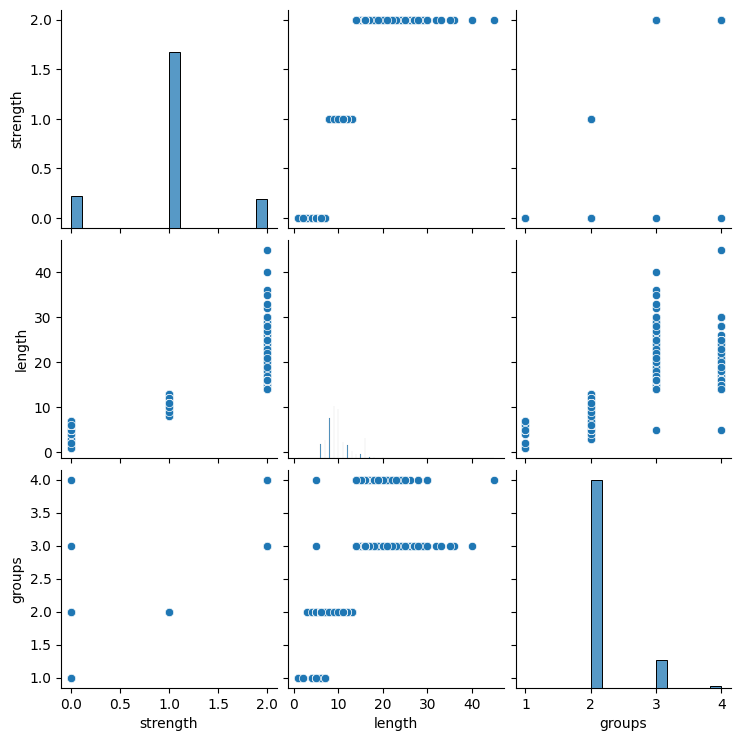

In [6]:
sns.pairplot(df);

Смущает распределение силы пароля в зависимости от длины пароля, взглянем поближе.

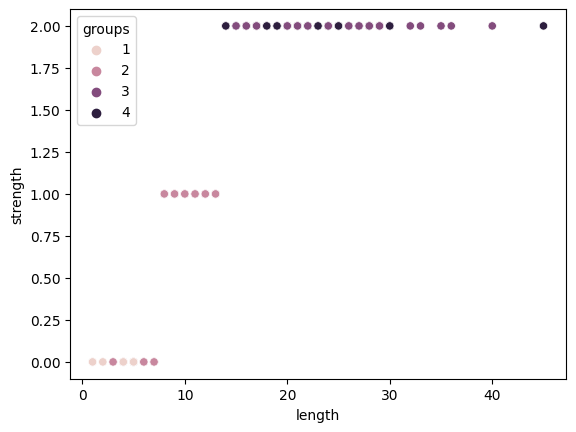

In [7]:
sns.scatterplot(df, x="length", y="strength", hue="groups");

Похоже, сила пароля зависит только длины пароля.
Если присмотреться к данным, пароли первого класса (уровня надёжности) имеют и длину от 8 до 13 символов включительно, и две группы разных символов. Логично было бы, если бы пароли такой длины, но содержащие 3 группы символов, получали второй (высший) уровень надёжности, но таких паролей нет в предоставленном датасете. А пароли с 3 и 4 разными группами символов и при этом 2-го класса надёжности имеют длину более 13 символов (кроме случаев с длиной меньше 8, которые сразу получают 0 класс). Отсюда не понятно, пароль получает уровень надёжности 2 за длину более 13 символов или за наличие 3+ групп символов (при длине более 7).
Складывается впечатление, что пароли длиной от 8 до 13 были специально приведены к верхнему или нижнему регистру,  чтобы озадачить исследователя датасета (поверить в реальность таких данных сложно).

Итого возможны два варианта алгоритма определения уровня сложности пароля, основываясь на этом датасете:
1. Длина пароля менее 8 - уровень 0, более 13 - уровень 2, остальные - уровень 1.
2. Длина пароля менее 8 - уровень 0, длина более 7 и количество групп символов более 2 - уровень 2, остальные - уровень 1.

Примечание: есть в наборе данных один пароль, который выбивается из это схемы, но, вероятней всего, это происходит по причине того, что символ "\\" игнорируется или не включается в группу спецсимволов алгоритмом разметки.

In [8]:
df[(df["length"] > 7) & (df["length"] < 14)]["groups"].unique()

array([2])

Можно построить ещё одну вычисляемую колонку "вычисленная надёжность пароля", рассчитываемую по предположенным  ранее алгоритмам и убедиться, что совпадение с размеченными данными будет 100%. Я не буду тут загромождать блокнот (этот алгоритм реализован во второй части ноутбука).

Здесь же можно из любопытства проверить, как справилась бы какая-то из моделей машинного обучения. Такое вычисление в пару ветвлений отлично описывается деревом решений (Decision Tree Classifier), попробуем обучить его на наших данных, предоставив ему один параметр (для первого алгоритма, зависящего только от длины) и два параметра - длину пароля и количество групп символов (для второго алгоритма). Я не буду разбивать данные на обучающий и тестовый наборы, о переобучении не может идти речи, цель просто увидеть, какая получится модель - должно быть два узла ветвлений и три листа - по одному на каждый класс.

In [9]:
df_X = df[["length"]]
df_y = df[["strength"]]
tree1 = DecisionTreeClassifier()
tree1.fit(df_X, df_y)
tree1.score(df_X, df_y)

1.0

Точность (accuracy) модели 1, т.е. она правильно предсказывает весь набор данных. Повторюсь, что о переобучении не может идти речи, модель не запомнила весь датасет, а построила корректные узлы дерева решений.
Посмотрим его графическое отображение.

[Text(0.4, 0.8333333333333334, 'X[0] <= 7.5\ngini = 0.415\nsamples = 100000\nvalue = [13428, 74278, 12294]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 13428\nvalue = [13428, 0, 0]'),
 Text(0.6, 0.5, 'X[0] <= 13.5\ngini = 0.244\nsamples = 86572\nvalue = [0, 74278, 12294]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 74278\nvalue = [0, 74278, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 12294\nvalue = [0, 0, 12294]')]

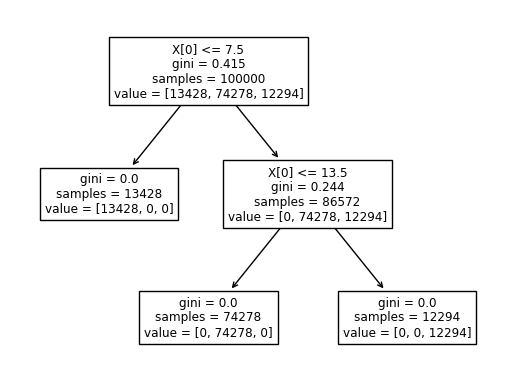

In [10]:
plot_tree(tree1)

Длина больше 7.5 и меньше 13.5 - обученное на данных дерево решений подтвердило первый алгоритм.
Проверим второй.

In [11]:
df_X = df[["length", "groups"]]
df_y = df[["strength"]]
tree2 = DecisionTreeClassifier(random_state=111222333)
tree2.fit(df_X, df_y)
tree2.score(df_X, df_y)

1.0

[Text(0.4, 0.8333333333333334, 'X[0] <= 7.5\ngini = 0.415\nsamples = 100000\nvalue = [13428, 74278, 12294]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 13428\nvalue = [13428, 0, 0]'),
 Text(0.6, 0.5, 'X[1] <= 2.5\ngini = 0.244\nsamples = 86572\nvalue = [0, 74278, 12294]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 74278\nvalue = [0, 74278, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 12294\nvalue = [0, 0, 12294]')]

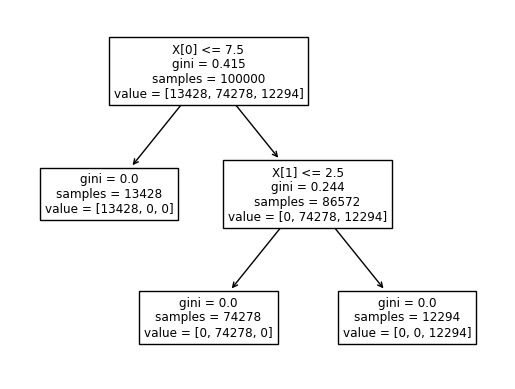

In [12]:
plot_tree(tree2)

Длина больше 7.5 и затем ветвление по кол-ву групп символов более 2.5 - второй предполагаемый алгоритм был найден деревом, правда, пришлось поиграть с параметром random_state, т.к. дерево могло построиться и по первому алгоритму (зависящему только от длины пароля).

# 2. Модель

Можно использовать полученные в первой части модели, но можно и обойтись без библиотек машинного обучения, реализовав простую функцию оценки сложности пароля. Просто чтобы поупражняться в программировании, реализуем оба алгоритма: первый, просто проверяющий длину, будет явно работать быстрее, а второй может пригодиться, если в будущем входные данные будут исправлены, т.е. появятся пароли средней длины с 3+ разных групп символов, которые скорее всего получат 2 класс надёжности.

Функции реализованы в виде генераторов для экономии памяти и поддержки ленивых вычислений. На вход подаётся любой iterable объект, отдающий строки (pandas.series, list, etc.), а отдаваемые значения также можно сложить в series, numpy.ndarray, array.array, list, etc.

In [13]:
def get_pwd_strength(pwd_it):
    if isinstance(pwd_it, str):
        raise ValueError("Передайте iterable строк, а не одну строку")
    for pwd in pwd_it:
        yield (1 + (len(pwd) > 13)) * (len(pwd) > 7)


MATCH_GROUPS = (r"[A-Z]",
                r"[a-z]",
                r"[0-9]",
                r"[`~!@#%&()|_,<>=:;'\"\+\-\*\[\]\.\/\?\$\^]",
                )

def get_pwd_strength2(pwd_it):
    if isinstance(pwd_it, str):
        raise ValueError("Передайте iterable строк, а не одну строку")
    for pwd in pwd_it:
        if len(pwd) < 8:
            yield 0
            continue
        count = 0
        for match_group in MATCH_GROUPS:
            count += 1 if re.search(match_group, pwd,) else 0
            if count > 2:
                break
        yield 1 + (count > 2)


Вся "модель" - небольшое количество строк тривиального кода.
А вообще функция определения уровня надёжности пароля укладывается в одну строку:

```get_password_strength = lambda pwd: (1 + (len(pwd) > 13)) * (len(pwd) > 7)```

Надеюсь, это может считаться лаконичным решением поставленной задачи. :)

Пример использования "модели":

In [14]:
df1 = pd.read_csv("passwords.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'passswords.csv'

In [15]:
pred = np.fromiter(get_pwd_strength(df1["password"]), np.ubyte)
pred

array([1, 2, 1, ..., 1, 0, 1], dtype=uint8)

Оценим точность алгоритма:

In [16]:
accuracy_score(df1["strength"], pred)

1.0

Т.к. у нас 100% точность определения класса, выбор метрики не имеет значения.

**Спасибо за внимание!**

PS: задача была бы сложней и интересней, если бы алгоритм вычисления уровня качества пароля был не такой очевидный. К примеру, если бы на сложность влияло использование словарных слов, подряд идущих значений (aaa, qwe, 123) и т.п., это вынудило бы применить более изощрённый feature engineering и использовать какие-то более сложные модели машинного обучения.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa689e8a-56c7-436d-ae52-a9da18e9b462' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>